# Reinforcement Learning Assigment

Name: Jamwal Snigdha <br>
Matriculation Number: G2304207H <br>
Email: SNIGDHA001@e.ntu.edu.sg


## ATTENTION <br>
The given code has been modified to include reward engineering, multiple algorithms and increase code reusibility. The modified and added code is commented with "ATTENTION".

In [ ]:
from typing import List, Tuple
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

The following class defines the grid world environment. The grid world looks like:

```
____________________________________________________________
|___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
|_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
|_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
|_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
|_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
```



## Reward Engineering

The original CliffBoxGridWorld class doesn't penalize the agent if it moved the box in a cell which is covered by cliffs on two connecting sides. Even though on doing this the game essentially ends because the agent can't move the box out of the corner without either the agent or box falling in the cliff. Therefore I have introduced a penalty of -1000 (same penalty as falling in the cliff) to ensure that the choosen model learns and reaches the optimum solution faster. The results of adding reward engineering is discussed further in Section

In [ ]:
AGENT = 'A'
BOX = 'B'
GOAL = 'G'
DANGER = 'x'
GRID = '_'


class CliffBoxGridWorld:
    """
    Cliff Box Pushing Grid World.
    """
    action_space = [1, 2, 3, 4]
    forces = {
        1: np.array([-1, 0]),
        2: np.array([1,  0]),
        3: np.array([0, -1]),
        4: np.array([0,  1]),
    }
    world_width = 14
    world_height = 6
    goal_pos = np.array([4, 13])
    init_agent_pos = np.array([5, 0])
    init_box_pos = np.array([4, 1])
    danger_region = [
        [(2, 3), (5, 3)],
        [(0, 6), (3, 6)],
        [(0, 7), (2, 7)],
        [(3, 11), (5, 11)],
        [(2, 12), (5, 12)],
    ]

    def __init__(self,
                 episode_length=100,
                 render=False,
                 ):
        """
        The grid world looks like:
        ____________________________________________________________
        |___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
        |_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
        |_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
        |_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
        |_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
        """
        # Environment configurations.
        self.episode_length = episode_length
        self.render = render
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        # Visualization.
        if self.render:
            self.world = np.chararray((self.world_height, self.world_width))
            self.last_agent_pos = copy.deepcopy(self.agent_pos)
            self.last_box_pos = copy.deepcopy(self.box_pos)
            self.world[:] = GRID
            for region in self.danger_region:
                A, B = region
                assert A[1] == B[1], "A[1] != B[1]"
                self.world[A[0]:B[0]+1, A[1]] = DANGER
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
            self.world[self.box_pos[0], self.box_pos[1]] = BOX
            self.world[self.goal_pos[0], self.goal_pos[1]] = GOAL

    def reset(self):
        """
        Resets the environment.

        Returns:
            The initial state (agent position and box position).
        """
        self.timesteps = 0
        self.action_history = []
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        return tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])
    ## ATTENTION: Reward engineering code added
    def step(self, actions: int, reward_eng = False):
        """
        Args: actions (a list of int).

        Returns:
            The next state, reward, done, info.
        """
        self.action_history.append(actions)

        # Update the state.
        force = self.forces[actions]
        # check if the agent is near the box
        if np.sum(np.abs(self.agent_pos - self.box_pos)) == 1:
            # check if box is moved
            if all(self.agent_pos + force == self.box_pos):
                # check out of boundary
                self.box_pos = self._check_pos_boundary(pos=self.box_pos + force, box_hard_boundary=True)
        # move the agent
        new_agent_pos = self._check_pos_boundary(self.agent_pos + force)
        if not all(new_agent_pos == self.box_pos):
            self.agent_pos = new_agent_pos
        state = tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

        # Calculate the rewards
        done = self.timesteps == self.episode_length - 1
        # the distance between agents and box
        dist = np.sum(np.abs(self.agent_pos - self.box_pos))
        reward = -1  # -1 for each step
        reward -= dist
        # if agents or box is off the cliff
        if self._check_off_cliff(self.agent_pos) or self._check_off_cliff(self.box_pos):
            reward += -1000
            done = True

        if all(self.box_pos == self.goal_pos):
            reward += 1000
            done = True

        reward -= np.sum(np.abs(self.box_pos - self.goal_pos))

        # gives negative reward when the box is pushed to a cell with cliffs on diagonal cells
        if reward_eng and self._check_diag_cliff(self.box_pos):
          reward += -1000


        if self.render:
            self._update_render()

        self.timesteps += 1
        info = {}

        return state, reward, done, info

    def print_world(self):
        """
        Render the world in the command line.
        """
        if len(self.action_history) > 0:
            print(f'Action: {self.action_history[-1]}')
        print(self.world)

    def _check_pos_boundary(self, pos, box_hard_boundary: bool = False):
        """
        Move the given position within the world bound.
        """
        if pos[0] < 0:
            pos[0] = 0
        if pos[0] >= self.world_height:
            pos[0] = self.world_height - 1
        if pos[1] < 0:
            pos[1] = 0
        if pos[1] >= self.world_width:
            pos[1] = self.world_width - 1

        if box_hard_boundary:
            if pos[0] == 0:
                pos[0] += 1
            elif pos[0] == self.world_height - 1:
                pos[0] = self.world_height - 2
            if pos[1] == 0:
                pos[1] += 1

        return pos

    def _check_off_cliff(self, pos):
        """
        Check if the given position is off cliff.
        """
        for region in self.danger_region:
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            if A[0] <= pos[0] <= B[0] and pos[1] == A[1]:
                return True
        return False

    ## ATTENTION: Function used for the reward engineering .
    def _check_diag_cliff(self, pos):
      """
      Check if given position is surrounded by diagonal cliff.
      """
      corner_list = [[1,3],
                     [1,4],
                     [2,3],
                     [2,4]]
      for corner in corner_list:
        if self._check_off_cliff(np.array(pos) + self.forces[corner[0]]) and self._check_off_cliff(np.array(pos) + self.forces[corner[1]]):
          return True

      return False



    def _update_render(self):
        """
        Update the render information.
        """
        if not all(self.last_agent_pos == self.agent_pos):
                pos = self.last_agent_pos
                if (pos[0] != self.goal_pos[0]) or (pos[1] != self.goal_pos[1]):
                    self.world[pos[0], pos[1]] = GRID

        if not all(self.last_box_pos == self.box_pos):
            pos = self.last_box_pos
            if self.world[pos[0], pos[1]].decode('UTF-8') not in {AGENT}:
                self.world[pos[0], pos[1]] = GRID

        if (self.agent_pos[0] != self.goal_pos[0]) or (self.agent_pos[1] != self.goal_pos[1]):
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
        self.world[self.box_pos[0], self.box_pos[1]] = BOX
        self.last_box_pos = copy.deepcopy(self.box_pos)
        self.last_agent_pos = copy.deepcopy(self.agent_pos)

Here is one example random agent class:

In [ ]:
class RandomAgent:
    def __init__(self, env, num_episodes):
        self.action_space = [1, 2, 3, 4]
        self.env = env
        self.num_episodes = num_episodes

    def act(self):
        """Returns a random choice of the available actions"""
        return np.random.choice(self.action_space)

    def learn(self):
        rewards = []

        for _ in range(self.num_episodes):
            cumulative_reward = 0 # Initialise values of each game
            state = self.env.reset()
            done = False
            while not done: # Run until game terminated
                action = self.act()
                next_state, reward, done, info = self.env.step(action)
                cumulative_reward += reward
                state = next_state
            rewards.append(cumulative_reward)

        return rewards

You need to complete the learn() method of the following class to implement your RL algorithm.

In [ ]:
class RLAgent:
    def __init__(self, env, num_episodes, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.action_space = env.action_space
        self.q_table = dict() # Store all Q-values in a dictionary
        # Loop through all possible grid spaces, create sub-dictionary for each
        for agent_x in range(env.world_height):
            for agent_y in range(env.world_width):
                for box_x in range(env.world_height):
                    for box_y in range(env.world_width):
                        # Populate sub-dictionary with zero values for possible moves
                        self.q_table[(agent_x, agent_y, box_x, box_y)] = {k: 0 for k in self.action_space}

        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def act(self, state):
        """Returns the (epsilon-greedy) optimal action from Q-Value table."""
        if np.random.uniform(0,1) < self.epsilon:
            action = self.action_space[np.random.randint(0, len(self.action_space))]
        else:
            q_values_of_state = self.q_table[state]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])

        return action

# ATTENTION: Adding a parameter method to choose between Q-learning and SARSA
# By default will take Q-Learning algorithm
    def learn(self, method = "qlearning", reward_eng = False):
        """Updates Q-values iteratively."""
        rewards = []

        for _ in range(self.num_episodes):
            cumulative_reward = 0 # Initialise values of each game
            state = self.env.reset()
            done = False
            while not done: # Run until game terminated
              action = self.act(state)
              next_state, reward, done, info = self.env.step(action, reward_eng = reward_eng)
              if method == "qlearning":
                self.q_table[state][action]= self.q_table[state][action] + self.alpha * ( reward + self.gamma*max(self.q_table[next_state].values()) - self.q_table[state][action])
              elif method == "sarsa":
                self.q_table[state][action]= self.q_table[state][action] + self.alpha * ( reward + self.gamma*self.q_table[next_state][self.act(next_state)] - self.q_table[state][action])
              state = next_state
              cumulative_reward = cumulative_reward + reward

            rewards.append(cumulative_reward)

        return rewards

Here is the game interface where you can manually move the agent.

In [ ]:
env = CliffBoxGridWorld(render=True)
env.reset()
env.print_world()
done = False
rewards = []

while not done:
    action = int(input("Please input the actions (up: 1, down: 2, left: 3, right: 4): "))
    state, reward, done, info = env.step(action)
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')

Example code to step random agent in the environment.

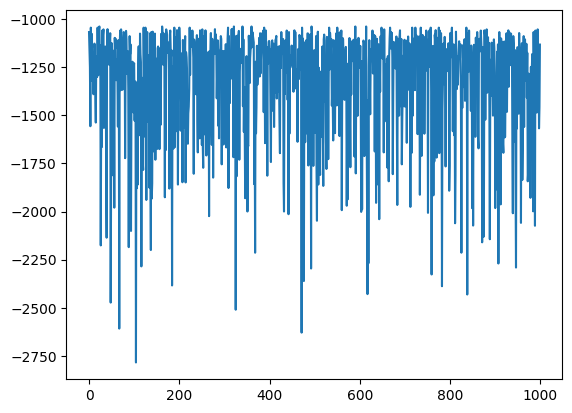

In [ ]:
# Initialize the environment and agent
env = CliffBoxGridWorld()
agent = RandomAgent(env, num_episodes=1000)
rewards = agent.learn()

# Plot the learning curve
plt.plot(rewards)

In [ ]:
## ATTENTION: The plot code has been put into a function to increase code reusability
def smooth_plot(rewards):
  # Smooth plot
  weight=0.99
  last = rewards[0]
  smoothed = []
  for v in rewards:
      smoothed_val = last * weight + (1 - weight) * v
      smoothed.append(smoothed_val)
      last = smoothed_val

  # Plot the learning curve
  ## ATTENTION: Code for a easier to understand plot has been added
  plt.xlabel("Episodes")
  plt.ylabel("Reward")
  plt.plot(smoothed)


You need to complete the following method to visualize your training results.

In [ ]:
def visualize(q_table):
    v_table = np.zeros((CliffBoxGridWorld.world_height,CliffBoxGridWorld.world_width))
    # policy = np.zeros((CliffBoxGridWorld.world_height,CliffBoxGridWorld.world_width))
    v_sum = [[[] for _ in range(CliffBoxGridWorld.world_width)] for _ in range(CliffBoxGridWorld.world_height)] #storing the list containing all the


    # TODO: Visualize learned V-table and policy.
    for key, value in q_table.items():
      actions = list(q_table[key].keys())
      policy = actions[np.argmax([value[i] for i in range(1, 5)])]
      v_sum[key[0]][key[1]].append(value[policy])


    for i in range(0,CliffBoxGridWorld.world_height):
      for j in range(0,CliffBoxGridWorld.world_width):
        v_table[i][j] = np.mean(v_sum[i][j])

    # visualizing the learned V-table
    print("V-Table:")
    np.set_printoptions(precision=2, linewidth = 100)

    for i in range(len(v_table)):
      print(i,v_table[i])

    # visualize the Policy
    print("Learned Policy")
    env = CliffBoxGridWorld(render=True)
    state = env.reset()
    env.print_world()
    done = False
    cumulative_reward = []
    while not done:
      # best_action = np.argmax([q_table[state][i] for i in range(1,5)])
      action_list = list(q_table[state].keys())
      action = action_list[np.argmax([q_table[state][i] for i in range(1,5)])] # taking the action with the highest reward

      state, reward, done, info = env.step(action)
      cumulative_reward.append(reward)
      print(f'step: {env.timesteps}, state: {state}, actions: {action},␣reward: {reward}')
      env.print_world()

    print(f'rewards: {sum(cumulative_reward)}')
    print(f'action history: {env.action_history}')


Train your own agent!

In [ ]:
## ATTENTION: The hyperparameters used to train Q-Learning and SARSA. Both the algorithms' hyperparameters have been kept the same to make it easier to compare their performance
episodes = 15000
epsilon = 0.01
alpha = 0.1
gamma = 0.99

## Q-Learning

Q-learning is a model-free Off Policy reinforcement learning algorithm to learn the value of an action in a particular state. It does not require a model of the environment (hence "model-free"), and it can handle problems with stochastic transitions and rewards without requiring adaptations.

It's update rule is:

$Q(s_t,a_t)←Q(s_t,a_t)+ \alpha [r_{t+1}+γ\,\underset{a′}{max}\,Q(s_{t+1},a′)−Q(s_t,a_t)]$

### Q-Learning algorithm without reinforcement learning

#### Training

In [ ]:
# increased the number of episodes to 10000 to see the trajectory of the rewards even though the rewards stabalize around 8000 episodes
# ATTENTION: Some variable names have been modified to make it easier to differenciate between Q-Leaning and SARSA variables
env = CliffBoxGridWorld()
Qagent = RLAgent(env, num_episodes = episodes, epsilon = epsilon, alpha = alpha, gamma = gamma )
Qrewards = Qagent.learn()

#### Plotting the Learning Curve

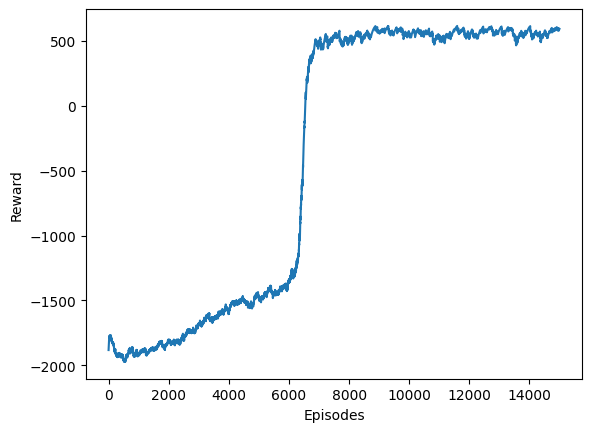

In [ ]:
smooth_plot(Qrewards)

#### Visualizing the V-Table and Policy

In [ ]:
visualize(Qagent.q_table)

V-Table:
0 [-32.41 -35.65 -33.92 -31.52 -32.59 -24.     0.     0.   -32.7  -22.48 -21.86 -11.44 -18.    -7.35]
1 [-26.7  -22.2  -23.03 -23.96 -23.17 -22.22   0.     0.   -18.66 -12.26 -11.62 -10.07  -7.35  -7.75]
2 [-32.64 -21.94 -20.14   0.   -15.95 -23.01   0.     0.   -23.75 -22.92 -12.91 -14.15   0.   -14.65]
3 [-28.92 -22.59 -29.94   0.   -29.86 -22.23   0.   -28.48 -27.84  -6.57 -14.82   0.     0.   -25.25]
4 [-31.45 -22.58 -31.39   0.   -20.29 -20.3  -19.03 -18.14 -16.88 -15.82 -16.97   0.     0.   -24.35]
5 [-32.27 -25.52 -33.63   0.   -30.69 -30.67 -30.46 -31.69 -18.94 -25.48 -15.43   0.     0.   -23.71]
Learned Policy
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']

### Q-Learning algorithm with rewards Engineering

#### Training

In [ ]:
##ATTENTION: Testing the results with reward engineering
env = CliffBoxGridWorld()
QagentRE = RLAgent(env, num_episodes = episodes, epsilon = epsilon, alpha = alpha, gamma = gamma )
QrewardsRE = QagentRE.learn(reward_eng = True)

#### Plotting the Learning Curve

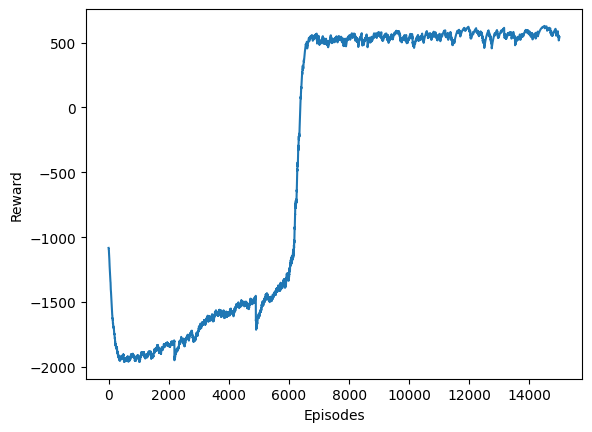

In [ ]:
smooth_plot(QrewardsRE)

#### Visualizing the V-Table and Policy

In [ ]:
visualize(QagentRE.q_table)

V-Table:
0 [-32.99 -34.32 -34.97 -31.16 -32.07 -24.61   0.     0.   -31.94 -21.44 -21.04 -11.19 -17.07  -5.94]
1 [-24.07 -22.17 -22.27 -21.89 -22.19 -21.81   0.     0.   -17.59 -11.94 -10.2   -9.03  -7.38  -4.28]
2 [-32.45 -21.87 -19.51   0.   -15.44 -24.69   0.     0.   -23.8  -22.23 -12.1  -12.1    0.   -13.7 ]
3 [-26.11 -22.35 -31.92   0.   -29.27 -21.07   0.   -27.74 -26.69  -4.58 -15.48   0.     0.   -24.36]
4 [-34.09 -22.3  -31.34   0.   -20.35 -19.32 -18.42 -19.61 -16.99 -14.67 -14.22   0.     0.   -23.51]
5 [-32.91 -25.81 -35.28   0.   -30.98 -31.52 -29.58 -29.41 -25.07 -24.03 -14.28   0.     0.   -23.03]
Learned Policy
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']

## State–action–reward–state–action (SARSA)

SARSA is a slight variation of the Q-Learning algorithm. It is an On Policy and uses the action performed by the current policy to learn the Q-value.

It's update rule is: <br>
$$Q(s_t,a_t)←Q(s_t,a_t)+α [r_{t+1}+γ\,\,Q(s_{t+1},a_{t+1})−Q(s_t,a_t)]$$

###SARSA algorithm without rewards engineering

#### Training

In [ ]:
# increased the number of episodes to 10000 to see the trajectory of the rewards even though the rewards stabalize around 8000 episodes
# ATTENTION: Some variable names have been modified to make it easier to differenciate between Q-Leaning and SARSA variables
env = CliffBoxGridWorld()
Sagent = RLAgent(env, num_episodes = episodes, epsilon = epsilon, alpha = alpha, gamma = gamma )
Srewards = Sagent.learn(method = "sarsa")

####Plotting the Learning Curve

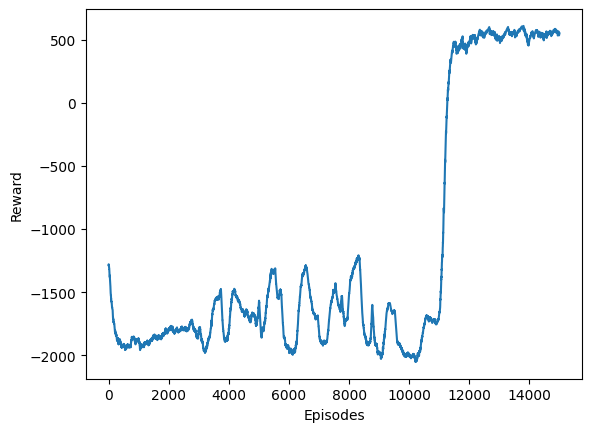

In [ ]:
smooth_plot(Srewards)

####Visualizing the V-Table and the Policy

In [ ]:
visualize(Sagent.q_table)

V-Table:
0 [-66.98 -66.82 -67.48 -66.07 -62.81 -57.6    0.     0.   -63.64 -57.02 -56.04 -50.23 -49.13 -40.64]
1 [-58.08 -53.58 -53.56 -51.63 -60.25 -55.22   0.     0.   -53.45 -46.83 -44.53 -44.2  -41.06 -39.09]
2 [-62.78 -52.73 -56.17   0.   -53.69 -54.91   0.     0.   -61.71 -54.34 -48.09 -55.3    0.   -44.84]
3 [-63.42 -53.13 -62.77   0.   -59.29 -55.5    0.   -60.28 -60.18 -47.38 -52.6    0.     0.   -55.56]
4 [-60.9  -52.36 -61.53   0.   -57.28 -53.89 -58.46 -53.87 -51.08 -48.44 -49.83   0.     0.   -54.62]
5 [-63.26 -58.88 -68.03   0.   -66.59 -62.39 -62.05 -62.25 -61.52 -57.07 -51.75   0.     0.   -54.12]
Learned Policy
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']

###SARSA algorithm with reward engineering

#### Training

In [ ]:
##ATTENTION: Testing the results with reward engineering
env = CliffBoxGridWorld()
SagentRE = RLAgent(env, num_episodes = episodes, epsilon = epsilon, alpha = alpha, gamma = gamma )
SrewardsRE = SagentRE.learn(reward_eng = True ,method = "sarsa")

####Plotting the Learning Curve

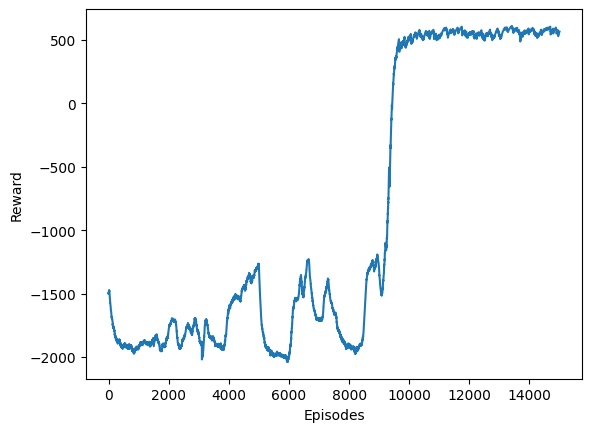

In [ ]:
smooth_plot(SrewardsRE)

####Visualizing the V-Table and the Policy

In [ ]:
visualize(SagentRE.q_table)

V-Table:
0 [-54.52 -53.91 -56.17 -52.3  -53.25 -46.37   0.     0.   -44.09 -45.37 -42.48 -33.76 -37.52 -28.19]
1 [-45.73 -42.14 -43.51 -46.26 -45.85 -43.91   0.     0.   -34.74 -34.68 -34.39 -31.69 -30.45 -25.48]
2 [-52.01 -42.71 -45.69   0.   -42.59 -44.1    0.     0.   -42.82 -32.86 -34.86 -43.81   0.   -34.11]
3 [-49.1  -42.07 -51.64   0.   -48.71 -43.45   0.   -48.43 -32.06 -35.53 -43.41   0.     0.   -45.  ]
4 [-51.73 -41.61 -50.86   0.   -41.69 -42.07 -40.82 -43.05 -37.74 -37.   -45.48   0.     0.   -44.22]
5 [-52.84 -46.87 -55.48   0.   -51.6  -54.48 -51.63 -49.15 -46.53 -37.69 -45.85   0.     0.   -43.8 ]
Learned Policy
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']

##Comparison
 To compare the performance of Q-Learning and SARSA algorithms and see the effect of reinforcement learning I have reduced the learning rate $α$ to 0.02 and increased the number of episodes to $50,000$. The rest of the parameters are still the same.

In [ ]:
episodes = 50000
alpha = 0.02
env = CliffBoxGridWorld()

In [ ]:
start = time.time()
Qagent = RLAgent(env, num_episodes = episodes, epsilon = epsilon, alpha = alpha, gamma = gamma )
Qrewards = Qagent.learn()
print("Time Taken for Q-Learning: ", time.time()-start)
start = time.time()
QagentRL = RLAgent(env, num_episodes = episodes, epsilon = epsilon, alpha = alpha, gamma = gamma )
QrewardsRL = QagentRL.learn(reward_eng=True)
print("Time Taken for Q-Learning with reward engineering: ", time.time()-start)
start = time.time()
Sagent = RLAgent(env, num_episodes = episodes, epsilon = epsilon, alpha = alpha, gamma = gamma )
Srewards = Sagent.learn(method = "sarsa")
print("Time Taken for SARSA: ", time.time()-start)
start = time.time()
SagentRL = RLAgent(env, num_episodes = episodes, epsilon = epsilon, alpha = alpha, gamma = gamma )
SrewardsRL = SagentRL.learn(method = "sarsa",reward_eng=True)
print("Time Taken for SARSA with reward engineering: ", time.time()-start)

Time Taken for Q-Learning:  336.9257197380066
Time Taken for Q-Learning with reward engineering:  304.46713495254517
Time Taken for SARSA:  381.45063948631287
Time Taken for SARSA with reward engineering:  415.4330704212189


In [ ]:
def smoothed(rewards):
  weight=0.99
  last = rewards[0]
  smoothed = []
  for v in rewards:
      smoothed_val = last * weight + (1 - weight) * v
      smoothed.append(smoothed_val)
      last = smoothed_val
  return smoothed


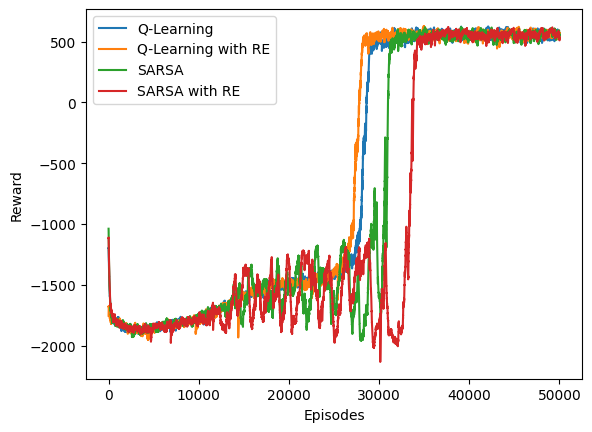

In [ ]:
# Plot the learning curve of all the algorithms
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(smoothed(Qrewards), label = "Q-Learning")
plt.plot(smoothed(QrewardsRL), label = "Q-Learning with RE")
plt.plot(smoothed(Srewards), label = "SARSA")
plt.plot(smoothed(SrewardsRL), label = "SARSA with RE")
plt.legend()

As expected the Q-Learning with RE learns the optimal policy with the maximum reward faster than all the other methods and takes the least time to compute.
We can see from the learning plot that both the SARSA methods were oscillating around $-1500$ reward till $30,000$ episodes. SARSA might be a better choice than Q-Learning when we have large state spaces but for the assignment it can be seen that Q-Learning is better in terms of accuracy and computational time.

##Conclusion

For the given Grid World there is only one optimal policy: <br>  $[4, 1, 1, 1, 3, 1, 4, 4, 4, 4, 1, 4, 2, 2, 2, 3, 2, 4, 4, 4, 4, 4, 2, 4, 1, 1, 1, 3, 1, 4, 4, 4, 1, 4, 2, 2, 2]$
for the agent to follow with the maximum possible reward of $642$.
From Section 2 and 3 we can see that for all methods the box reaches the goal without either the agent or box falling in the cliff or the  maximum time step being exceeded. For all the methods except SARSA with RE (which takes an action path with the reward $632$) arrive at the same optimal policy. This is because SARSA aims to find the near optimal policy unlike Q-Learning which aims to find the optimal policy. SARSA is also more conservative during learning which is why when a new penalty was introduced during reward engineering it found a near optimal policy where the box maintained the maximum possible distance from the cells with cliffs on two connecting sides to reach the goal. Through this it can be concluded that for the purpose of our assignment Q-Learning with RE is the best model. But in a real life scenerio it might be safer to use SARSA with RE for a similar scenerio.



## References

1. https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/
2. https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial#q-learning-python-tutorial
3. https://www.geeksforgeeks.org/sarsa-reinforcement-learning/

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc textcomp
!pip install pypandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package textcomp


In [ ]:
!jupyter nbconvert --to PDF ./RLAgent.ipynb

[NbConvertApp] Converting notebook ./RLAgent.ipynb to PDF
[NbConvertApp] Support files will be in RLAgent_files/
[NbConvertApp] Making directory ./RLAgent_files
[NbConvertApp] Making directory ./RLAgent_files
[NbConvertApp] Making directory ./RLAgent_files
[NbConvertApp] Making directory ./RLAgent_files
[NbConvertApp] Making directory ./RLAgent_files
[NbConvertApp] Making directory ./RLAgent_files
[NbConvertApp] Writing 176549 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 298666 bytes to RLAgent.pdf
